<a href="https://colab.research.google.com/github/andrewyyip/Predicting_Pneumonia/blob/master/nflbowl_2021_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#import packages

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
plt.style.use('ggplot')

import numpy as np
import seaborn as sns

In [3]:
#read files

df_games = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/games.csv')
df_players = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/players.csv')
df_plays = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/plays.csv')
df_week1 = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/week1_merged.csv')
df_targets = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/targetedReceiver.csv')
df_covers = pd.read_csv('/content/gdrive/My Drive/NFL/NFLbowl-2021/data/coverages_week1.csv')

#change column names
df_games.columns = [x.lower() for x in df_games.columns]
df_players.columns = [x.lower() for x in df_players.columns]
df_plays.columns = [x.lower() for x in df_plays.columns]
df_week1.columns = [x.lower() for x in df_week1.columns]
df_targets.columns = [x.lower() for x in df_targets.columns]
df_covers.columns = [x.lower() for x in df_covers.columns]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pitch Control / Ball Influence

In soccer (or actual football), the idea of pitch control presented by Javier Fernandez and Luke Bornn in the 2019 paper "Wide Open Spaces" has become increasingly popular. [This post by Robert Hickman](https://www.robert-hickman.eu/post/fall_back_in_to_space/) does a great job of explaining how it works, and much of the work done for this model is based on [Will Thompson's work here](https://colab.research.google.com/drive/1V75UgfJEfCWgbfxnG4OuB1WpvqahUJPU). 
Pitch control gives us a way to see what areas of the field a team has more 'influence' over, and in turn where a team should want the ball to be. Let's apply this idea in an NFL context to see how passes perform when thrown into areas of different influences.

We will use ball influence / pitch control as a feature in our model, along with the x y coordinates of the players and football, to predict if a pass play will be complete or not. Since we only have coverages for week 1, we'll use week 1 for our model for now.

In [4]:
xx,yy = np.meshgrid(np.linspace(0,120,121),np.linspace(0,54,55))

def ball_influence_f(player_data, football_data):
  x = player_data.x.values[0]
  y = player_data.y.values[0]
  ballx = football_data.x.values[0]
  bally = football_data.y.values[0]
  s = player_data.s.values[0]
  theta = (player_data.dir.values[0]) * np.pi / 180
  sx = s * np.sin(theta)
  sy = s * np.cos(theta)
  sxy = [sx, sy]
  mu = np.array([x,y]) + np.array(sxy) * 0.5
  Rot = np.array([[np.sin(theta), -np.cos(theta)],[np.cos(theta),np.sin(theta)]])

  Srat = (s / 13) ** 2
  d = np.linalg.norm(np.array([x,y]) - np.array([ballx, bally]))
  #radius of ball influence is 10, unless d <= value
  if d <= 18:
    Ri = 4 + d**3/ (18**3/6)
  else:
    Ri = 10
  #Ri = np.minimum(4 + Ri**3/ (18**3/6),10) 
  S = np.array([[(1 + Srat) * Ri / 2, 0], [0, (1 - Srat) * Ri / 2]])
  Sigma = np.matmul(Rot,S)
  Sigma = np.matmul(Sigma,S)
  Sigma = np.matmul(Sigma,np.linalg.inv(Rot))
  from scipy.stats import multivariate_normal as mvn
  return (mvn.pdf(np.c_[xx.flatten(), yy.flatten()], mu, Sigma) / mvn.pdf([x, y], mu, Sigma)).reshape(55,121)


In [6]:
#some plays are flagged with only some of these labels, so this is a list of the pass arrived labels possible we will use the first 
#occurence of one of these labels in our model
ball_arrived = ['pass_arrived', 'pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception', 
                'pass_tipped', 'pass_outcome_touchdown', 'pass_shovel']

In [7]:
#make all the x coordinates go in the same direction
def x_mod_function(row):
  if row.playdirection == 'left':
    result = row.absoluteyardlinenumber - row.x

  elif row.playdirection == 'right':
    result = row.x - row.absoluteyardlinenumber

  return result

In [8]:
#merge target list with player names and positions
df_targets = pd.merge(df_targets, df_players[['nflid', 'position', 'displayname']], how = 'left', left_on = 'targetnflid', right_on = 'nflid')

In [9]:
#get the frames where the pass arrived for all the plays in week 1.
df_ball_arrived = df_week1[df_week1.event.isin(ball_arrived)]

#Get the tracking data for the football
football = df_ball_arrived[df_ball_arrived.displayname == 'Football']

#group the plays by gameid and play id, and get the lowest numbered frame in the case where a play has multiple instances of ball_arrived labels
#ie pass_arrived at frame 20, pass_outcome_caught at frame 23, we would use frame 20
football = football.groupby(['gameid', 'playid'])[['frameid', 'x', 'y', 'playdirection', 'numberofpassrushers']].agg({'frameid':'min', 'x':'mean', 'y':'mean', 'playdirection':'max', 'numberofpassrushers':'max'}).reset_index()

#merge our play data with our football data from week 1
data = pd.merge(df_plays[['gameid', 'playid', 'passresult', 'absoluteyardlinenumber']], football, how = 'inner', on = ['gameid', 'playid'])

#appply our xmod function, making all of our x coordinates face the same direction
data['xmod'] = data.apply(x_mod_function, axis = 1)



In [10]:
#function to get the influence value at a given xy coordinate
def dataframe_z_function(row):  
  data = df_week1[(df_week1.gameid == row.gameid) & (df_week1.playid == row.playid) & (df_week1.event == 'pass_forward')]
  o = data[data.offdef == 'offense']
  d = data[data.offdef == 'defense']
  f = data[data.offdef == 'football']

  c_offense = np.zeros(121*55).reshape(55,121)
  c_defense = np.zeros(121*55).reshape(55,121)
  xx,yy = np.meshgrid(np.linspace(0,120,121),np.linspace(0,54,55))

  for player in o.displayname.value_counts().index:
    c_offense += ball_influence_f(o[(o.displayname == player)], f)

  for player in d.displayname.value_counts().index:
    c_defense += ball_influence_f(d[d.displayname == player], f)

  z = 1 / (1 + np.exp(-c_offense + c_defense))

  x = int(row.x)
  y = int(row.y)

  #if the y value is out of bounds, use the max y of either 54 or 0
  if y > 54:
    y = 54
  if y < 0:
    y = 0
  #if the x value is out of bounds, use the max x of either 120 or 0
  if x > 120:
    x = 120
  if x < 0:
    x = 0
  return z[y,x]  

In [11]:
#get the ball influence value (z) at the location the ball is thrown at
z = data.apply(dataframe_z_function, axis = 1)

In [12]:
data['z'] = z

In [13]:
#merge our data with the target data
data = pd.merge(data, df_targets[['gameid', 'playid', 'position', 'displayname']], how = 'left', on = ['gameid', 'playid'])

In [14]:
#make the pass result 1 if C, 0 if I or INT
data['result'] = data.passresult.apply(lambda x: 1 if x == 'C' else 0)
data.dropna(inplace=True)

## Random Forest Classifier Model

In [15]:
#random forest classifier to predict a pass as complete or not
#use xy coordinates and ball influence value (z) as features

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data[['xmod', 'y', 'z']]
y = data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

model = RandomForestClassifier(random_state = 19)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
df_results = pd.DataFrame({'y_test': y_test, 'y_pred':y_pred})
from sklearn.metrics import accuracy_score

print('Accuracy Score: %.2f' % accuracy_score(y_test, y_pred))

Accuracy Score: 0.77


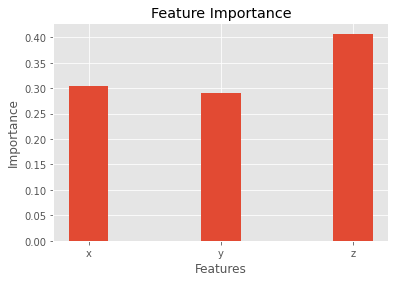

In [16]:
#quick look at feautre importance in our model
plt.bar(['x', 'y', 'z'], model.feature_importances_, width = 0.3)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

The model ended up using the ball influence (z) value as the most important feature in making it's predictions.

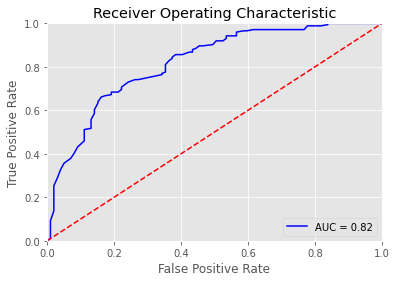

In [17]:
#ROC plot
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Our model looks like it does better than random guesses with an area under the curve of 0.82 (randomly guessing complete or not complete would produce an AUC of 0.5, represented here by the red line).

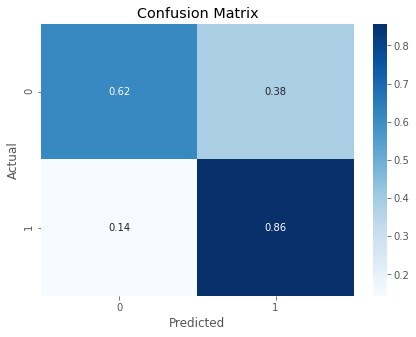

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Normalise
cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#plot confusion matrix
plt.figure(figsize = (7,5))
sns.heatmap(cm_normal, cmap = 'Blues', annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Our model looks like it does well with positive cases, and could use some work with negative ones. 

In [19]:
data['predict'] = model.predict_proba(X)[:,1]

## Defensive Coverage by Ball Influence

Now that we have a model that uses the influence value (z) as a major feature in it's predictions, let's take a closer look at the z value to see if we can gain any additional insights. Let's plot the average z value across the field as a heat map to see the pros and cons of a variety of NFL defensive coverages and see if any patterns emerge.

In [20]:
#merge coverage labels into tracking data
df_week1 = pd.merge(df_week1, df_covers, how = 'left', on = ['gameid', 'playid'])

In [21]:
#adjust the player direction angle based on the play going left or right
df_week1['dirmod'] = df_week1.apply(lambda x: -x.dir if x.playdirection == 'left' else x.dir, axis = 1)

In [22]:
#ball influence function using adjusted x values
def ball_influence_xmod_f(player_data, football_data):
  x = player_data.xmod.values[0] + 50
  y = player_data.y.values[0]
  ballx = football_data.xmod.values[0] + 50
  bally = football_data.y.values[0]
  s = player_data.s.values[0]
  theta = (player_data.dirmod.values[0]) * np.pi / 180
  sx = s * np.sin(theta)
  sy = s * np.cos(theta)
  sxy = [sx, sy]
  mu = np.array([x,y]) + np.array(sxy) * 0.5
  Rot = np.array([[np.sin(theta), -np.cos(theta)],[np.cos(theta),np.sin(theta)]])

  Srat = (s / 13) ** 2
  d = np.linalg.norm(np.array([x,y]) - np.array([ballx, bally]))
  #radius of ball influence is 10, unless d <= value
  if d <= 18:
    Ri = 4 + d**3/ (18**3/6)
  else:
    Ri = 10
  #Ri = np.minimum(4 + Ri**3/ (18**3/6),10) 
  S = np.array([[(1 + Srat) * Ri / 2, 0], [0, (1 - Srat) * Ri / 2]])
  Sigma = np.matmul(Rot,S)
  Sigma = np.matmul(Sigma,S)
  Sigma = np.matmul(Sigma,np.linalg.inv(Rot))
  from scipy.stats import multivariate_normal as mvn
  return (mvn.pdf(np.c_[xx.flatten(), yy.flatten()], mu, Sigma) / mvn.pdf([x, y], mu, Sigma)).reshape(55,121)

In [23]:
#pitch control function for entire field
def z_function(row):  
  data = df_week1[(df_week1.gameid == row.gameid) & (df_week1.playid == row.playid) & (df_week1.event.isin(ball_arrived))]
  o = data[data.offdef == 'offense']
  d = data[data.offdef == 'defense']
  f = data[data.offdef == 'football']

  c_offense = np.zeros(121*55).reshape(55,121)
  c_defense = np.zeros(121*55).reshape(55,121)
  xx,yy = np.meshgrid(np.linspace(0,120,121),np.linspace(0,54,55))

  for player in o.displayname.value_counts().index:
    c_offense += ball_influence_xmod_f(o[(o.displayname == player)], f)

  for player in d.displayname.value_counts().index:
    c_defense += ball_influence_xmod_f(d[d.displayname == player], f)

  z = 1 / (1 + np.exp(-c_offense + c_defense))

  return np.array(z, dtype = 'float')

In [24]:
#apply the z_function to get the pitch control for each play in week 1
df_covers['z'] = df_covers.apply(z_function, axis = 1)
df_covers['z'] = df_covers.z.apply(lambda x: np.nan if np.isnan(np.sum(x)) else x)
df_covers.dropna(inplace=True)

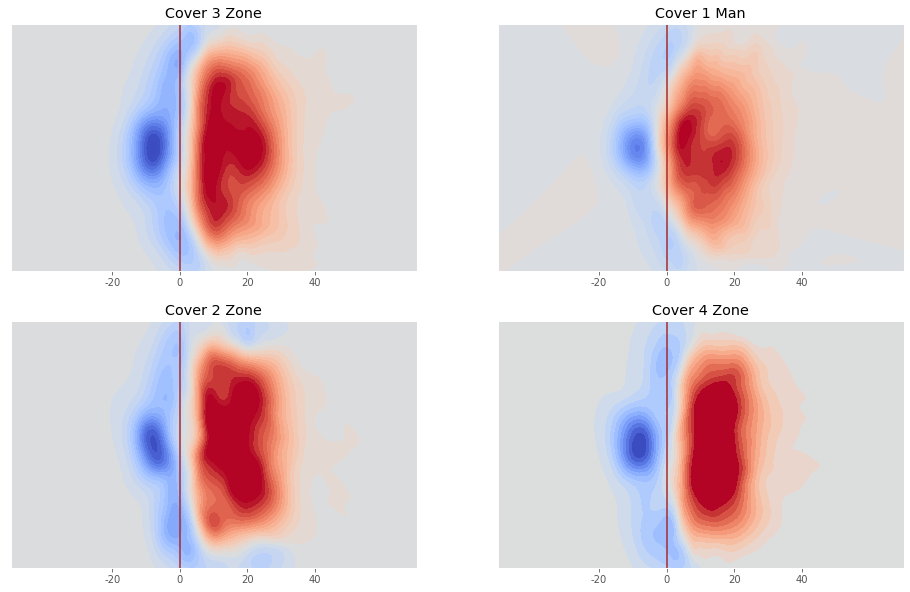

In [25]:
#plot a the average pitch control as a heatmap grouped by defensive coverage formation
plt.figure(figsize = (16,10))

plt.subplot(2,2,1)
plt.contourf(xx, yy, df_covers[df_covers.coverage == 'Cover 3 Zone'].z.sum() / len(df_covers[df_covers.coverage == 'Cover 3 Zone']), levels = 30, 
             vmin = 0.42, vmax = 0.58, cmap = 'coolwarm_r')
plt.axvline(50, c = 'Brown')
plt.title('Cover 3 Zone')
plt.xticks([30, 50, 70, 90], [-20, 0, 20, 40])
plt.yticks([])

plt.subplot(2,2,2)
plt.contourf(xx, yy, df_covers[df_covers.coverage == 'Cover 1 Man'].z.sum() / len(df_covers[df_covers.coverage == 'Cover 1 Man']), levels = 30, 
             vmin = 0.42, vmax = 0.58, cmap = 'coolwarm_r')
plt.axvline(50, c = 'Brown')
plt.title('Cover 1 Man')
plt.xticks([30, 50, 70, 90], [-20, 0, 20, 40])
plt.yticks([])

plt.subplot(2,2,3)
plt.contourf(xx, yy, df_covers[df_covers.coverage == 'Cover 2 Zone'].z.sum() / len(df_covers[df_covers.coverage == 'Cover 2 Zone']), levels = 30, 
             vmin = 0.42, vmax = 0.58, cmap = 'coolwarm_r')
plt.axvline(50, c = 'Brown')
plt.title('Cover 2 Zone')
plt.xticks([30, 50, 70, 90], [-20, 0, 20, 40])
plt.yticks([])

plt.subplot(2,2,4)
plt.contourf(xx, yy, df_covers[df_covers.coverage == 'Cover 4 Zone'].z.sum() / len(df_covers[df_covers.coverage == 'Cover 4 Zone']), levels = 30, 
             vmin = 0.42, vmax = 0.58, cmap = 'coolwarm_r')
plt.axvline(50, c = 'Brown')
plt.title('Cover 4 Zone')
plt.xticks([30, 50, 70, 90], [-20, 0, 20, 40])
plt.yticks([])

plt.show()

These were the 4 most commonly used coverage schemes from week 1 of the 2018 season. In general it looks like the zone defenses are good at defending the areas in the middle of the field(areas of solid red). However, it appears that they give up control of the short field (flat routes) as most of the areas near the line of scrimmage have more blue. By comparison, Cover 1 Man doesn't have as much control over the center (not as 'red') but they do not give up as much control over the line of scrimmage (not as 'blue'). If we take a closer look at Cover 2 Zone, we can also see that there is a clear weakness (blue patches) around both sidelines about 20 yards from the line of scrimmage. This is likely a result of having only 2 players cover so much real estate - the defense will have less influence over areas near the boundaries of the coverage zones.



In the future, teams can use their own coverage and tracking data to analyze how their defenses perform in various schemes. They'll be able to make adjustments and plug their weaknesses as they identify areas on the field that they do not have good influence over.